In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

In [3]:
# import data and create trainloader
class Cropper:
    def __call__(self, img):
        return transforms.functional.crop(img, 35, 54, 218, 336)
    
img_scale = 2

transform =  transforms.Compose(
    [
        transforms.Grayscale(),
        Cropper(),
        transforms.Resize((218 // img_scale, 336 // img_scale)),
        transforms.ToTensor(),
    ]
)

test_dataset = datasets.ImageFolder(
    "data/test",
    transform=transform
)

test_data = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])
test_labels = torch.Tensor([test_dataset[i][1] for i in range(len(test_dataset))])

In [4]:
# construct CNN
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.pool = nn.MaxPool2d(3, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bn = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 20, 5)
        self.conv3 = nn.Conv2d(20, 20, 3)
        self.conv4 = nn.Conv2d(20, 20, 3)
        self.fc1 = nn.Linear(41760, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn(self.conv1(x))))
        res1 = x.view(x.shape[0], -1).clone()
        x = self.pool(F.relu(self.bn(self.conv2(x))))
        res2 = x.view(x.shape[0], -1).clone()
        x = self.pool2(F.relu(self.bn(self.conv3(x))))
        res3 = x.view(x.shape[0], -1)
        x = F.relu(self.bn(self.conv4(x)))
        x = x.view(x.shape[0], -1)
        x = torch.cat((x, res1, res2, res3), dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
model = ConvNet()
model.load_state_dict(torch.load('torch_model.pth'))
model.eval()

ConvNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=41760, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)

In [14]:
def occlude(image, label):
    w, h = tuple(image.shape)
    res = torch.zeros_like(image)
    s_len = 45
    for x in range(s_len, w-s_len):
        print(x)
        for y in range(s_len, h-s_len):
            occluded = image.clone().detach()
            occluded[x-s_len:x+s_len, y-s_len:y+s_len] = 0
            res[x, y] = nn.Softmax()(model(occluded.reshape(1, 1, w, h)))[0, label]
    return res

In [15]:
image = test_data[0]
res = occlude(image.reshape(109, 168), int(test_labels[0]))

45


/Users/augustbrocchini/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


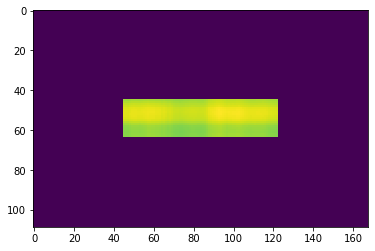

In [16]:
plt.imshow(res.detach())